In [114]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import random

import utils

In [115]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [ ]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    output = np.zeros((out_size,out_size, sample.shape[2]), np.uint32)
    row = 0 
    col = 0

    while (row + patch_size) <= out_size:
      col = 0
      while (col + patch_size) <= out_size:
        rand_row = random.randrange(0, sample.shape[0]-patch_size)
        rand_col = random.randrange(0, sample.shape[0]-patch_size)
        output[row:(row + patch_size), col:(col + patch_size)] =  sample[rand_row:(rand_row + patch_size), rand_col:(rand_col + patch_size)]
        col += patch_size
      row += patch_size
    return output
    


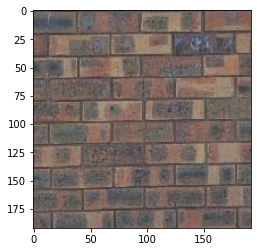

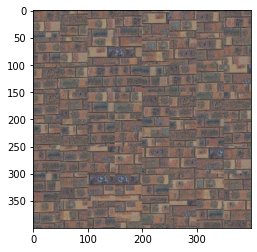

In [ ]:
sample_img_fn = 'bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 400  # change these parameters as needed
patch_size = 50
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [ ]:
def ssd_patch(template, mask, image):
  """
  """
  b,g,r = cv2.split(image/255)
  b_template, g_template,r_template = cv2.split(template)

  ssd_costb = ((mask*b_template)**2).sum() - 2 * cv2.filter2D(b, ddepth=-1, kernel = mask*b_template) + cv2.filter2D(b**2, ddepth=-1, kernel=mask)
  ssd_costg = ((mask*g_template)**2).sum() - 2 * cv2.filter2D(g, ddepth=-1, kernel = mask*g_template) + cv2.filter2D(g**2, ddepth=-1, kernel=mask)
  ssd_costr = ((mask*r_template)**2).sum() - 2 * cv2.filter2D(r, ddepth=-1, kernel = mask*r_template) + cv2.filter2D(r**2, ddepth=-1, kernel=mask)
  total_cost = ssd_costb + ssd_costg + ssd_costr
  return total_cost

def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    #randomly sample and fill in upper left part of the image:
    output = np.zeros((out_size, out_size, sample.shape[2]), np.float32)
    rand_row = random.randrange(0, sample.shape[0]-patch_size)
    rand_col = random.randrange(0, sample.shape[0]-patch_size)
    output[0:patch_size, 0:patch_size] =  sample[rand_row:(rand_row + patch_size), rand_col:(rand_col+patch_size)]/255

    horizontal_mask = np.zeros((patch_size,patch_size), np.float32)     
    vertical_mask = np.zeros((patch_size,patch_size),np.float32)
    mask = np.zeros((patch_size,patch_size),np.float32)          

    #create each type of mask:
    for row in horizontal_mask:
      row[0:overlap] = 1
    vertical_mask[0:overlap][:] = 1
    for row in mask:
      row[0:overlap] = 1
    mask[0:overlap][:] = 1 
    
    row = 0
    half_patch = int(patch_size/2)
    col = patch_size - overlap
    while ((row + patch_size) <= out_size):      
      while ((col + patch_size) <= out_size):
        template = output[row:(row + patch_size), col:(col + patch_size)]
        if (row == 0): #only overlap horizontally
          row_patch, col_patch = choose_sample(ssd_patch(template, horizontal_mask, sample), tol, patch_size)
        elif (col == 0): #only overlap vertically 
          row_patch, col_patch = choose_sample(ssd_patch(template, vertical_mask, sample), tol, patch_size)
        else: #overlap horizontally and vertically
          row_patch, col_patch = choose_sample(ssd_patch(template, mask, sample), tol, patch_size)
        output[row:(row + patch_size), col:(col + patch_size)] = sample[(row_patch-half_patch):(row_patch + half_patch + 1), (col_patch-half_patch):(col_patch + half_patch + 1)]/255
        col += (patch_size - overlap)
      col = 0
      row += (patch_size - overlap)
    return output


def choose_sample(cost_image, tol, patch_size):
  """
    Finds the patch with the lowest cost
    :param cost_image: image where each pixel holds a cost
    :param tol: tells how many of the lowest cost patches to randomly choose from
    :param patch_size, int
  """
  rows = []
  cols = []
  height = cost_image.shape[0] - patch_size
  width = cost_image.shape[1] - patch_size
  image = cost_image[patch_size:height, patch_size:width]
  sorted_costs = sorted(image.flatten())
  sorted_costs = sorted_costs[0:tol]
  for row in range(0, cost_image.shape[0]):
    for col in range(0, cost_image.shape[1]):
      if (cost_image[row][col] in sorted_costs): 
        rows.append(row)
        cols.append(col)
      if (len(rows) == tol):
        break
  choose =  random.randrange(0, len(rows))
  return rows[choose], cols[choose]

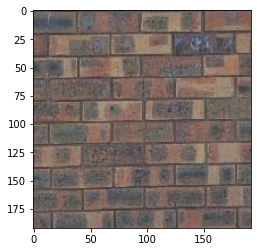

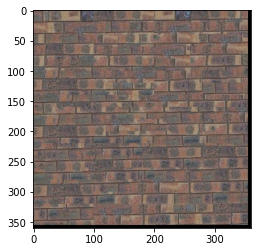

In [ ]:
sample_img_fn = 'bricks_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 360  # change these parameters as needed
patch_size = 35
overlap = 15
tol = 3
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [ ]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [100]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    #randomly sample and fill in upper left part of the image:
    output = np.zeros((out_size, out_size, sample.shape[2]), np.float32)
    rand_row = random.randrange(0, sample.shape[0]-patch_size)
    rand_col = random.randrange(0, sample.shape[0]-patch_size)
    output[0:patch_size, 0:patch_size] =  sample[rand_row:(rand_row + patch_size), rand_col:(rand_col+patch_size)]/255
         
    horizontal_mask = np.zeros((patch_size,patch_size), np.float32)     
    vertical_mask = np.zeros((patch_size,patch_size),np.float32)
    mask = np.zeros((patch_size,patch_size),np.float32)          

    #create each type of mask:
    for row in horizontal_mask:
      row[0:overlap] = 1
    vertical_mask[0:overlap][:] = 1
    for row in mask:
      row[0:overlap] = 1
    mask[0:overlap][:] = 1 
    
    row = 0
    half_patch = int(patch_size/2)
    col = patch_size - overlap

    while ((row + patch_size) <= out_size):      
      while ((col + patch_size) <= out_size):
        template = output[row:(row + patch_size), col:(col + patch_size)]
        if (row == 0): #only overlap horizontally
          row_patch, col_patch = choose_sample(ssd_patch(template, horizontal_mask, sample), tol, patch_size)
          sample_overlap = sample[(row_patch-half_patch):(row_patch + half_patch + 1), (col_patch-half_patch):(col_patch - half_patch + overlap)]/255
          output_overlap = output[row:(row + patch_size), (col):(col+overlap)]
          err_patch = ((output_overlap - sample_overlap)**2).sum(axis=-1).T

          overlap_mask = utils.cut(err_patch).T
          inv_overlap_mask = np.where(overlap_mask == 0, 1, 0)

          # plt.figure()
          # plt.imshow(output_overlap)

          # plt.figure()
          # plt.imshow(sample_overlap)

          # plt.figure()
          # plt.imshow(err_patch)

          # plt.figure()
          # plt.imshow(overlap_mask)

          # plt.figure()
          # plt.imshow(horizontal_mask)

          # plt.figure()
          # plt.imshow(vertical_mask)

          # plt.figure()
          # plt.imshow(mask)

          o_b, o_g, o_r = cv2.split(output_overlap)
          s_b, s_g, s_r = cv2.split(sample_overlap)

          o_b = o_b * inv_overlap_mask 
          o_g = o_g  * inv_overlap_mask 
          o_r = o_r * inv_overlap_mask
          output_overlap = cv2.merge((o_b,o_g,o_r))

          s_b = s_b * overlap_mask  
          s_g = s_g * overlap_mask 
          s_r = s_r * overlap_mask
          sample_overlap = cv2.merge((s_b,s_g,s_r))

          output[row:(row + patch_size), col:(col + patch_size)] = sample[(row_patch-half_patch):(row_patch + half_patch + 1), (col_patch-half_patch):(col_patch + half_patch + 1)]/255
          output[row:(row + patch_size), col:(col + overlap)] = output_overlap + sample_overlap
          
        elif (col == 0): #only overlap vertically 
          row_patch, col_patch = choose_sample(ssd_patch(template, vertical_mask, sample), tol, patch_size)
          sample_overlap = sample[(row_patch-half_patch):(row_patch-half_patch+overlap), (col_patch - half_patch):(col_patch + half_patch + 1)]/255
          output_overlap = output[(row):(row + overlap), col:(col + patch_size)]
          err_patch = ((output_overlap - sample_overlap)**2).sum(axis=-1)
          overlap_mask = utils.cut(err_patch)
          inv_overlap_mask = np.where(overlap_mask == 0, 1, 0)

          o_b, o_g, o_r = cv2.split(output_overlap)
          s_b, s_g, s_r = cv2.split(sample_overlap)

          o_b = o_b * inv_overlap_mask 
          o_g = o_g  * inv_overlap_mask 
          o_r = o_r * inv_overlap_mask
          output_overlap = cv2.merge((o_b,o_g,o_r))

          s_b = s_b * overlap_mask  
          s_g = s_g * overlap_mask 
          s_r = s_r * overlap_mask
          sample_overlap = cv2.merge((s_b,s_g,s_r))

          output[row:(row + patch_size), col:(col + patch_size)] = sample[(row_patch-half_patch):(row_patch + half_patch + 1), (col_patch-half_patch):(col_patch + half_patch + 1)]/255
          output[row:(row+overlap), col:(col+patch_size)] = output_overlap + sample_overlap

        else: #overlap horizontally and vertically
          row_patch, col_patch = choose_sample(ssd_patch(template, horizontal_mask, sample), tol, patch_size)
          sample_overlap_vert = sample[(row_patch-half_patch):(row_patch + half_patch + 1), (col_patch-half_patch):(col_patch - half_patch + overlap)]/255
          output_overlap_vert = output[row:(row + patch_size), (col):(col+overlap)]
          err_patch_vert = ((output_overlap_vert - sample_overlap_vert)**2).sum(axis=-1).T
          vertical_seam = utils.cut(err_patch_vert).T

          sample_overlap_horiz = sample[(row_patch-half_patch):(row_patch-half_patch+overlap), (col_patch - half_patch):(col_patch + half_patch + 1)]/255
          output_overlap_horiz = output[(row):(row + overlap), col:(col + patch_size)]
          err_patch_horiz = ((output_overlap - sample_overlap)**2).sum(axis=-1)
          horizontal_seam = utils.cut(err_patch_horiz)

          combined_mask = np.logical_and(horizontal_seam[0:overlap, 0:overlap], vertical_seam[0:overlap, 0:overlap])
          inv_combined_mask = np.where(combined_mask == 0, 1, 0)
        
          inv_vertical_seam = np.where(vertical_seam == 0, 1, 0)
          inv_horiz_seam = np.where(horizontal_seam == 0, 1, 0)

          ov_b, ov_g, ov_r = cv2.split(output_overlap_vert)
          sv_b, sv_g, sv_r = cv2.split(sample_overlap_vert)

          oh_b, oh_g, oh_r = cv2.split(output_overlap_horiz)
          sh_b, sh_g, sh_r = cv2.split(sample_overlap_horiz)

          #Upper left hand corner of overlap
          ov_b[(0):(overlap),(0):(overlap)] *=  inv_combined_mask[0:(overlap), 0:(overlap)]
          ov_g[(0):(overlap),(0):(overlap)] *=  inv_combined_mask[0:(overlap), 0:(overlap)]
          ov_r[(0):(overlap),(0):(overlap)] *=  inv_combined_mask[0:(overlap), 0:(overlap)]

          oh_b[(0):(overlap),(0):(overlap)] *=  combined_mask[0:(overlap), 0:(overlap)]
          oh_g[(0):(overlap),(0):(overlap)] *=  combined_mask[0:(overlap), 0:(overlap)]
          oh_r[(0):(overlap),(0):(overlap)] *=  combined_mask[0:(overlap), 0:(overlap)]

          #Left vertical overlap
          ov_b[(overlap):(patch_size),(0):(overlap)] *=  inv_vertical_seam[(overlap):(patch_size),(0):(overlap)]
          ov_g[(overlap):(patch_size),(0):(overlap)] *=  inv_vertical_seam[(overlap):(patch_size),(0):(overlap)]
          ov_r[(overlap):(patch_size),(0):(overlap)] *=  inv_vertical_seam[(overlap):(patch_size),(0):(overlap)]

          sv_b[(overlap):(patch_size),(0):(overlap)] *=  vertical_seam[(overlap):(patch_size),(0):(overlap)] 
          sv_g[(overlap):(patch_size),(0):(overlap)] *=  vertical_seam[(overlap):(patch_size),(0):(overlap)]
          sv_r[(overlap):(patch_size),(0):(overlap)] *=  vertical_seam[(overlap):(patch_size),(0):(overlap)]


          #Upper horizontal overlap
          oh_b[(0):(overlap),(overlap):(patch_size)] *=  inv_horiz_seam[(0):(overlap),(overlap):(patch_size)] 
          oh_g[(0):(overlap),(overlap):(patch_size)] *=  inv_horiz_seam[(0):(overlap),(overlap):(patch_size)] 
          oh_r[(0):(overlap),(overlap):(patch_size)] *=  inv_horiz_seam[(0):(overlap),(overlap):(patch_size)]

          sh_b[(0):(overlap),(overlap):(patch_size)] *= horizontal_seam[(0):(overlap),(overlap):(patch_size)]
          sh_g[(0):(overlap),(overlap):(patch_size)] *= horizontal_seam[(0):(overlap),(overlap):(patch_size)]
          sh_r[(0):(overlap),(overlap):(patch_size)] *= horizontal_seam[(0):(overlap),(overlap):(patch_size)]
        
          #Combine everything back together
          combined_vert = cv2.merge((ov_b[(0):(overlap),(0):(overlap)],ov_g[(0):(overlap),(0):(overlap)],ov_r[(0):(overlap),(0):(overlap)]))
          combined_horiz = cv2.merge((oh_b[(0):(overlap),(0):(overlap)],oh_g[(0):(overlap),(0):(overlap)],oh_r[(0):(overlap),(0):(overlap)]))

          output_overlap_vertf = cv2.merge((ov_b[(overlap):(patch_size),(0):(overlap)],ov_g[(overlap):(patch_size),(0):(overlap)],ov_r[(overlap):(patch_size),(0):(overlap)]))
          sample_overlap_vertf = cv2.merge((sv_b[(overlap):(patch_size),(0):(overlap)],sv_g[(overlap):(patch_size),(0):(overlap)],sv_r[(overlap):(patch_size),(0):(overlap)]))

          output_overlap_horizf = cv2.merge((oh_b[(0):(overlap),(overlap):(patch_size)],oh_g[(0):(overlap),(overlap):(patch_size)],oh_r[(0):(overlap),(overlap):(patch_size)]))
          sample_overlap_horizf = cv2.merge((sh_b[(0):(overlap),(overlap):(patch_size)],sh_g[(0):(overlap),(overlap):(patch_size)],sh_r[(0):(overlap),(overlap):(patch_size)]))

          #Put everything into output image
          output[(row+overlap):(row + patch_size), (col+overlap):(col + patch_size)] = sample[(row_patch-half_patch +overlap):(row_patch + half_patch + 1), (col_patch-half_patch + overlap):(col_patch + half_patch + 1)]/255
          output[row:(row+overlap), (col + overlap):(col+patch_size)] = output_overlap_horizf + sample_overlap_horizf
          output[(row + overlap):(row + patch_size), col:(col + overlap)] = output_overlap_vertf + sample_overlap_vertf
          output[row:(row+overlap), col:(col+overlap)] = combined_vert + combined_horiz

        col += (patch_size - overlap)

      col = 0
      row += (patch_size - overlap)

    return output

def ssd_patch(template, mask, image):
  """
  """
  b,g,r = cv2.split(image/255)
  b_template, g_template,r_template = cv2.split(template)

  ssd_costb = ((mask*b_template)**2).sum() - 2 * cv2.filter2D(b, ddepth=-1, kernel = mask*b_template) + cv2.filter2D(b**2, ddepth=-1, kernel=mask)
  ssd_costg = ((mask*g_template)**2).sum() - 2 * cv2.filter2D(g, ddepth=-1, kernel = mask*g_template) + cv2.filter2D(g**2, ddepth=-1, kernel=mask)
  ssd_costr = ((mask*r_template)**2).sum() - 2 * cv2.filter2D(r, ddepth=-1, kernel = mask*r_template) + cv2.filter2D(r**2, ddepth=-1, kernel=mask)
  total_cost = ssd_costb + ssd_costg + ssd_costr

  return total_cost

def choose_sample(cost_image, tol, patch_size):
  """
    Finds the patch with the lowest cost
    :param cost_image: image where each pixel holds a cost
    :param tol: tells how many of the lowest cost patches to randomly choose from
    :param patch_size, int
  """
  rows = []
  cols = []
  height = cost_image.shape[0] - patch_size
  width = cost_image.shape[1] - patch_size
  image = cost_image[patch_size:height, patch_size:width]
  sorted_costs = sorted(image.flatten())
  sorted_costs = sorted_costs[0:tol]
  for row in range(0, cost_image.shape[0]):
    for col in range(0, cost_image.shape[1]):
      if (cost_image[row][col] in sorted_costs): 
        rows.append(row)
        cols.append(col)
      if (len(rows) == tol):
        break
  choose =  random.randrange(0, len(rows))
  return rows[choose], cols[choose]

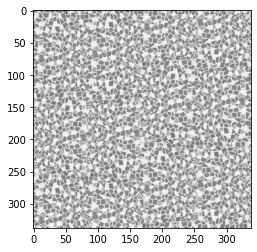

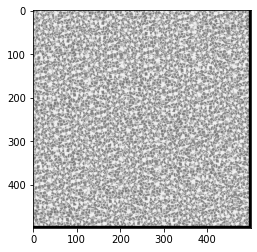

In [107]:
sample_img_fn = 'floor_texture.jfif' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 500  # change these parameters as needed
patch_size = 35
overlap = 15
tol = 3
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    # plt.figure(figsize=(8, 8))
    plt.figure()
    plt.imshow(res)
   

### part IV: Texture Transfer (30 pts)

In [110]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    output = np.zeros((guidance_im.shape[0], guidance_im.shape[1], sample.shape[2]), np.float32)
    rand_row = random.randrange(0, guidance_im.shape[0]-patch_size)
    rand_col = random.randrange(0, guidance_im.shape[1]-patch_size)
    output[0:patch_size, 0:patch_size] =  sample[rand_row:(rand_row + patch_size), rand_col:(rand_col+patch_size)]/255
         
    horizontal_mask = np.zeros((patch_size,patch_size), np.float32)     
    vertical_mask = np.zeros((patch_size,patch_size),np.float32)
    mask = np.zeros((patch_size,patch_size),np.float32)          

    #create each type of mask:
    for row in horizontal_mask:
      row[0:overlap] = 1
    vertical_mask[0:overlap][:] = 1
    for row in mask:
      row[0:overlap] = 1
    mask[0:overlap][:] = 1 
    
    row = 0
    half_patch = int(patch_size/2)
    col = patch_size - overlap

    while ((row + patch_size) <= guidance_im.shape[0]):      
      while ((col + patch_size) <= guidance_im.shape[1]):
        template = output[row:(row + patch_size), col:(col + patch_size)]
        if (row == 0): #only overlap horizontally
          row_patch, col_patch = choose_sample(ssd_patch(template, horizontal_mask, sample, guidance_im[row:(row + patch_size), col:(col + patch_size)], alpha), tol, patch_size)
          sample_overlap = sample[(row_patch-half_patch):(row_patch + half_patch + 1), (col_patch-half_patch):(col_patch - half_patch + overlap)]/255
          output_overlap = output[row:(row + patch_size), (col):(col+overlap)]
          err_patch = ((output_overlap - sample_overlap)**2).sum(axis=-1).T
          overlap_mask = utils.cut(err_patch).T
          inv_overlap_mask = np.where(overlap_mask == 0, 1, 0)

          o_b, o_g, o_r = cv2.split(output_overlap)
          s_b, s_g, s_r = cv2.split(sample_overlap)

          o_b = o_b * inv_overlap_mask 
          o_g = o_g  * inv_overlap_mask 
          o_r = o_r * inv_overlap_mask
          output_overlap = cv2.merge((o_b,o_g,o_r))

          s_b = s_b * overlap_mask  
          s_g = s_g * overlap_mask 
          s_r = s_r * overlap_mask
          sample_overlap = cv2.merge((s_b,s_g,s_r))

          output[row:(row + patch_size), col:(col + patch_size)] = sample[(row_patch-half_patch):(row_patch + half_patch + 1), (col_patch-half_patch):(col_patch + half_patch + 1)]/255
          output[row:(row + patch_size), col:(col + overlap)] = output_overlap + sample_overlap
          
        elif (col == 0): #only overlap vertically 
          row_patch, col_patch = choose_sample(ssd_patch(template, vertical_mask, sample, guidance_im[row:(row + patch_size), col:(col + patch_size)], alpha), tol, patch_size)
          sample_overlap = sample[(row_patch-half_patch):(row_patch-half_patch+overlap), (col_patch - half_patch):(col_patch + half_patch + 1)]/255
          output_overlap = output[(row):(row + overlap), col:(col + patch_size)]
          err_patch = ((output_overlap - sample_overlap)**2).sum(axis=-1)
          overlap_mask = utils.cut(err_patch)
          inv_overlap_mask = np.where(overlap_mask == 0, 1, 0)

          o_b, o_g, o_r = cv2.split(output_overlap)
          s_b, s_g, s_r = cv2.split(sample_overlap)

          o_b = o_b * inv_overlap_mask 
          o_g = o_g  * inv_overlap_mask 
          o_r = o_r * inv_overlap_mask
          output_overlap = cv2.merge((o_b,o_g,o_r))

          s_b = s_b * overlap_mask  
          s_g = s_g * overlap_mask 
          s_r = s_r * overlap_mask
          sample_overlap = cv2.merge((s_b,s_g,s_r))

          output[row:(row + patch_size), col:(col + patch_size)] = sample[(row_patch-half_patch):(row_patch + half_patch + 1), (col_patch-half_patch):(col_patch + half_patch + 1)]/255
          output[row:(row+overlap), col:(col+patch_size)] = output_overlap + sample_overlap

        else: #overlap horizontally and vertically
          row_patch, col_patch = choose_sample(ssd_patch(template, horizontal_mask, sample, guidance_im[row:(row + patch_size), col:(col + patch_size)], alpha), tol, patch_size)
          sample_overlap_vert = sample[(row_patch-half_patch):(row_patch + half_patch + 1), (col_patch-half_patch):(col_patch - half_patch + overlap)]/255
          output_overlap_vert = output[row:(row + patch_size), (col):(col+overlap)]
          err_patch_vert = ((output_overlap_vert - sample_overlap_vert)**2).sum(axis=-1).T
          vertical_seam = utils.cut(err_patch_vert).T

          sample_overlap_horiz = sample[(row_patch-half_patch):(row_patch-half_patch+overlap), (col_patch - half_patch):(col_patch + half_patch + 1)]/255
          output_overlap_horiz = output[(row):(row + overlap), col:(col + patch_size)]
          err_patch_horiz = ((output_overlap - sample_overlap)**2).sum(axis=-1)
          horizontal_seam = utils.cut(err_patch_horiz)

          combined_mask = np.logical_and(horizontal_seam[0:overlap, 0:overlap], vertical_seam[0:overlap, 0:overlap])
          inv_combined_mask = np.where(combined_mask == 0, 1, 0)
        
          inv_vertical_seam = np.where(vertical_seam == 0, 1, 0)
          inv_horiz_seam = np.where(horizontal_seam == 0, 1, 0)

          ov_b, ov_g, ov_r = cv2.split(output_overlap_vert)
          sv_b, sv_g, sv_r = cv2.split(sample_overlap_vert)

          oh_b, oh_g, oh_r = cv2.split(output_overlap_horiz)
          sh_b, sh_g, sh_r = cv2.split(sample_overlap_horiz)

          #Upper left hand corner of overlap
          ov_b[(0):(overlap),(0):(overlap)] *=  inv_combined_mask[0:(overlap), 0:(overlap)]
          ov_g[(0):(overlap),(0):(overlap)] *=  inv_combined_mask[0:(overlap), 0:(overlap)]
          ov_r[(0):(overlap),(0):(overlap)] *=  inv_combined_mask[0:(overlap), 0:(overlap)]

          oh_b[(0):(overlap),(0):(overlap)] *=  combined_mask[0:(overlap), 0:(overlap)]
          oh_g[(0):(overlap),(0):(overlap)] *=  combined_mask[0:(overlap), 0:(overlap)]
          oh_r[(0):(overlap),(0):(overlap)] *=  combined_mask[0:(overlap), 0:(overlap)]

          #Left vertical overlap
          ov_b[(overlap):(patch_size),(0):(overlap)] *=  inv_vertical_seam[(overlap):(patch_size),(0):(overlap)]
          ov_g[(overlap):(patch_size),(0):(overlap)] *=  inv_vertical_seam[(overlap):(patch_size),(0):(overlap)]
          ov_r[(overlap):(patch_size),(0):(overlap)] *=  inv_vertical_seam[(overlap):(patch_size),(0):(overlap)]

          sv_b[(overlap):(patch_size),(0):(overlap)] *=  vertical_seam[(overlap):(patch_size),(0):(overlap)] 
          sv_g[(overlap):(patch_size),(0):(overlap)] *=  vertical_seam[(overlap):(patch_size),(0):(overlap)]
          sv_r[(overlap):(patch_size),(0):(overlap)] *=  vertical_seam[(overlap):(patch_size),(0):(overlap)]


          #Upper horizontal overlap
          oh_b[(0):(overlap),(overlap):(patch_size)] *=  inv_horiz_seam[(0):(overlap),(overlap):(patch_size)] 
          oh_g[(0):(overlap),(overlap):(patch_size)] *=  inv_horiz_seam[(0):(overlap),(overlap):(patch_size)] 
          oh_r[(0):(overlap),(overlap):(patch_size)] *=  inv_horiz_seam[(0):(overlap),(overlap):(patch_size)]

          sh_b[(0):(overlap),(overlap):(patch_size)] *= horizontal_seam[(0):(overlap),(overlap):(patch_size)]
          sh_g[(0):(overlap),(overlap):(patch_size)] *= horizontal_seam[(0):(overlap),(overlap):(patch_size)]
          sh_r[(0):(overlap),(overlap):(patch_size)] *= horizontal_seam[(0):(overlap),(overlap):(patch_size)]
        
          #Combine everything back together
          combined_vert = cv2.merge((ov_b[(0):(overlap),(0):(overlap)],ov_g[(0):(overlap),(0):(overlap)],ov_r[(0):(overlap),(0):(overlap)]))
          combined_horiz = cv2.merge((oh_b[(0):(overlap),(0):(overlap)],oh_g[(0):(overlap),(0):(overlap)],oh_r[(0):(overlap),(0):(overlap)]))

          output_overlap_vertf = cv2.merge((ov_b[(overlap):(patch_size),(0):(overlap)],ov_g[(overlap):(patch_size),(0):(overlap)],ov_r[(overlap):(patch_size),(0):(overlap)]))
          sample_overlap_vertf = cv2.merge((sv_b[(overlap):(patch_size),(0):(overlap)],sv_g[(overlap):(patch_size),(0):(overlap)],sv_r[(overlap):(patch_size),(0):(overlap)]))

          output_overlap_horizf = cv2.merge((oh_b[(0):(overlap),(overlap):(patch_size)],oh_g[(0):(overlap),(overlap):(patch_size)],oh_r[(0):(overlap),(overlap):(patch_size)]))
          sample_overlap_horizf = cv2.merge((sh_b[(0):(overlap),(overlap):(patch_size)],sh_g[(0):(overlap),(overlap):(patch_size)],sh_r[(0):(overlap),(overlap):(patch_size)]))

          #Put everything into output image
          output[(row+overlap):(row + patch_size), (col+overlap):(col + patch_size)] = sample[(row_patch-half_patch +overlap):(row_patch + half_patch + 1), (col_patch-half_patch + overlap):(col_patch + half_patch + 1)]/255
          output[row:(row+overlap), (col + overlap):(col+patch_size)] = output_overlap_horizf + sample_overlap_horizf
          output[(row + overlap):(row + patch_size), col:(col + overlap)] = output_overlap_vertf + sample_overlap_vertf
          output[row:(row+overlap), col:(col+overlap)] = combined_vert + combined_horiz

        col += (patch_size - overlap)

      col = 0
      row += (patch_size - overlap)


    return output


    
def ssd_patch(template, mask, sample_image, guidance_im, alpha):
    """
    """
    b,g,r = cv2.split(sample_image/255)
    b_template, g_template,r_template = cv2.split(template)


    ssd_costb = ((mask*b_template)**2).sum() - 2 * cv2.filter2D(b, ddepth=-1, kernel = mask*b_template) + cv2.filter2D(b**2, ddepth=-1, kernel=mask)
    ssd_costg = ((mask*g_template)**2).sum() - 2 * cv2.filter2D(g, ddepth=-1, kernel = mask*g_template) + cv2.filter2D(g**2, ddepth=-1, kernel=mask)
    ssd_costr = ((mask*r_template)**2).sum() - 2 * cv2.filter2D(r, ddepth=-1, kernel = mask*r_template) + cv2.filter2D(r**2, ddepth=-1, kernel=mask)
    ssd_overlap = ssd_costb + ssd_costg + ssd_costr

    # SSD_guidance is the SSD between the input sample and the patch in the guidance/correspondence image at the same position as the output patch.
    b,g,r = cv2.split(sample_image/255)
    b_guide, g_guide, r_guide = cv2.split(guidance_im/255)
    
    ssd_guideb = ((mask*b_guide)**2).sum() - 2 * cv2.filter2D(b, ddepth=-1, kernel = mask*b_guide) + cv2.filter2D(b**2, ddepth=-1, kernel=mask)
    ssd_guideg = ((mask*g_guide)**2).sum() - 2 * cv2.filter2D(g, ddepth=-1, kernel = mask*g_guide) + cv2.filter2D(g**2, ddepth=-1, kernel=mask)
    ssd_guider = ((mask*r_guide)**2).sum() - 2 * cv2.filter2D(r, ddepth=-1, kernel = mask*r_guide) + cv2.filter2D(r**2, ddepth=-1, kernel=mask)
    ssd_guidance = ssd_guideb + ssd_guideg + ssd_guider

    total_cost = alpha*ssd_overlap + (1-alpha)*ssd_guidance
    return total_cost

def choose_sample(cost_image, tol, patch_size):
    """
    Finds the patch with the lowest cost
    :param cost_image: image where each pixel holds a cost
    :param tol: tells how many of the lowest cost patches to randomly choose from
    :param patch_size, int
    """
    rows = []
    cols = []
    height = cost_image.shape[0] - patch_size
    width = cost_image.shape[1] - patch_size
    image = cost_image[patch_size:height, patch_size:width]
    sorted_costs = sorted(image.flatten())
    sorted_costs = sorted_costs[0:tol]
    for row in range(0, cost_image.shape[0]):
      for col in range(0, cost_image.shape[1]):
        if (cost_image[row][col] in sorted_costs): 
          rows.append(row)
          cols.append(col)
        if (len(rows) == tol):
          break
    choose =  random.randrange(0, len(rows))
    return rows[choose], cols[choose]




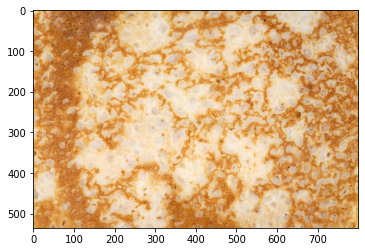

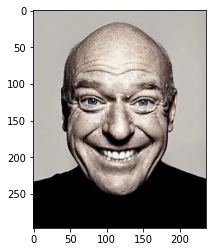

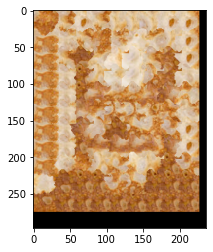

In [119]:
# load/process appropriate input texture and guidance images
texture_img =  cv2.cvtColor(cv2.imread("pancake_texture.jpg"), cv2.COLOR_BGR2RGB)
guidance_img = cv2.cvtColor(cv2.imread("smile.jfif"), cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(texture_img)

plt.figure()
plt.imshow(guidance_img)

patch_size = 35
overlap = 11
tol = 1
alpha = 0.05
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure()
plt.imshow(res)
plt.show()

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).